In [9]:
import glob
import os
from os.path import join
from numpy import genfromtxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
font = {'size'   : 20}
plt.rc('font', **font)

In [10]:
def get_sampled_data_dirs(root,mode='train'):
    if mode=='train':
        folder = '*/PCAP-01-12'
    elif mode=='test':
        folder = '*/PCAP-03-11'
        
    dirs = [d for d in glob.glob(join(root,folder))]
    return dirs

In [11]:
def get_pkt_count(dirs,ending):
    counts = []
    for d in dirs:
        num_sampled_pkts = 0
        filename = join(d,ending)
        #print("reading pkt count for filenbames ", filename)
        for f in glob.glob(filename):
            spc = int(open(f).readline())
            #print("spc = ", spc)
            num_sampled_pkts += spc
            #print()
        counts.append(num_sampled_pkts)
    return counts

In [12]:
def get_count_dir_names(dirs,ending):
    pkt_counts = np.array(get_pkt_count(dirs,ending))
    #flow_counts = np.array(get_flow_count(dirs))
    flow_counts = pkt_counts
    dir_names = np.array([os.path.basename(os.path.split(d)[0]) for d in dirs])
        
    sorted_index = np.argsort(dir_names)
    pkt_counts = pkt_counts[sorted_index]
    flow_counts = flow_counts[sorted_index]

    dir_names = dir_names[sorted_index]
    return flow_counts,pkt_counts,dir_names

In [13]:
import math
def autolabel(rects, whole_cnt,SR=10, xpos='center'):    
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    
    SI = 100/SR
    
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    max_height = 0
    for rect in rects:
        height = rect.get_height()
        if height > max_height:
            max_height = height
            
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}%'.format((100*height/whole_cnt)/SI),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 1),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

In [14]:
def color_code_sampler_by_name(dir_name):    
        if 'SFS' in dir_name:
            color='orange'
            label = 'SFS'
            full_name = 'SketchFlow'
        elif 'SGS' in dir_name:
            color = 'green'
            label = 'SGS'
            full_name = 'Sketch Guided'
        elif 'RPS' in dir_name:
            color = 'blue'
            label = 'RPS'
            full_name = 'Random Packet Sampling'
        elif 'FFS_(' in dir_name:
            color = 'red'
            label = 'FFS'
            full_name = 'Fast Filtered'
        elif 'SEL' in dir_name:
            color = 'purple'
            label = 'SEL'
            full_name = 'Selective Flow'
        elif 'whole' in dir_name or 'cicflow' in dir_name:
            color = 'gray'
            label = 'whole data'
        else:
            print('Investigate plot_comparison',dir_name)
        return label, full_name, color

In [15]:
def plot_comparison(dir_names,counts,ax,y_label,whole_cnt):
    colors = ['g','y','b','r','m','g','y','b','r','m']
    counts = counts/1000000
    whole_cnt = whole_cnt/1000000
    ind = np.arange(len(dir_names))*20
    width=15
    N = len(dirs)
    labels = []
    tick_labels = []
    
    for i,dir_name in enumerate(dir_names):
        label,full_name,color = color_code_sampler_by_name(dir_name)
        tick_labels.append(label)
        rects = ax.bar(ind[i],counts[i],label=label + ' - ' + full_name,width=width,color=color)
        autolabel(rects,whole_cnt,SR=10)
    #Add some text for labels, title and custom x-axis tick labels, etc.    
    #ax.set_title('Finding Equivalent Sampling Rate for comparision')
    ax.set_xticks(ind)
    #ax.set_xticklabels(tick_labels)
    ax.set_xticklabels(dir_names,rotation=45)
    ax.set_ylabel(y_label)
    ylim= 1.6*max(counts)
    ax.set_ylim(0,ylim)    
    ax.grid(linewidth=2)
    #ax.margins(0.15)
    

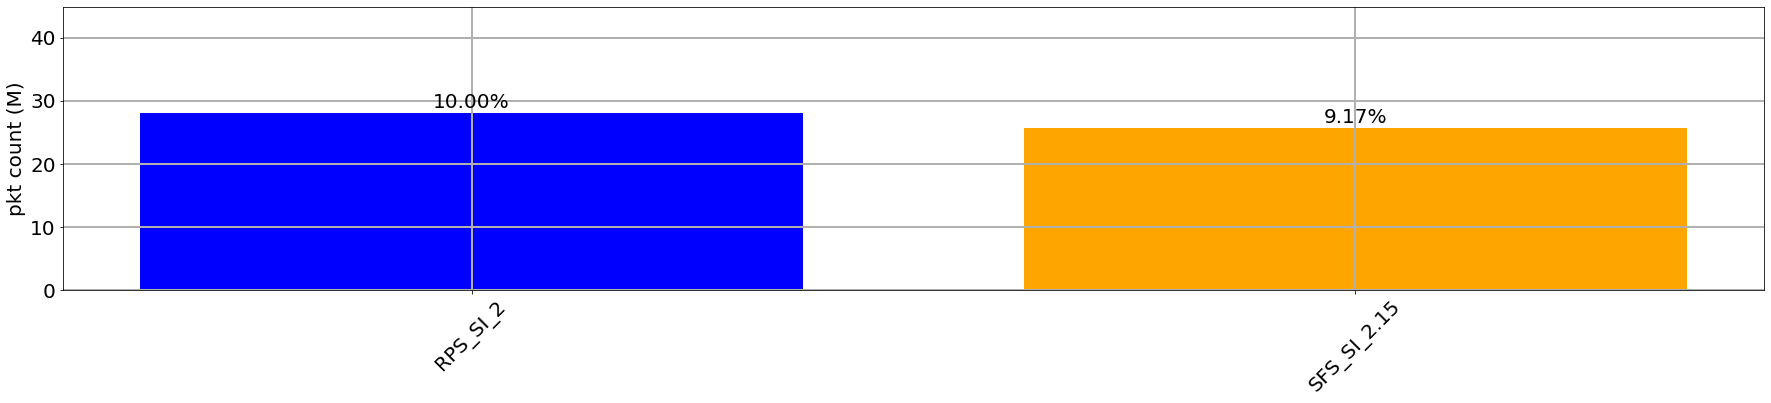

In [17]:
font = {'size'   : 20}
plt.rc('font', **font)
root = '/data/juma/data/ddos/CSVs_r_1.0/SR_50'
ending = '*_SPC.txt'
#mode = 'train'
mode='test'
dirs = get_sampled_data_dirs(root,mode=mode)
flow_counts,pkt_counts,dir_names = get_count_dir_names(dirs,ending)

# obtain baseline percentage(%)
baseline_index = np.where(dir_names=='RPS_SI_2')[0][0]
baseline_pkt_count = pkt_counts[baseline_index]
baseline_flow_count = flow_counts[baseline_index]

#by packet count
plt.clf()
plt.close()
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(25,6))
plot_comparison(dir_names,pkt_counts,ax,'pkt count (M)', baseline_pkt_count)
box = ax.get_position()
fig.tight_layout()
plt.savefig(join(root,'Inconsistency_train_pkt_sr_10.png'), bbox_inches='tight')
plt.show()